<a href="https://colab.research.google.com/github/MehdiMitiche/kaggle-red-wine-quality-regression/blob/main/red_wine_quality_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
#we import the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data = pd.read_csv("/content/gdrive/My Drive/red_wine_regression/winequality-red.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


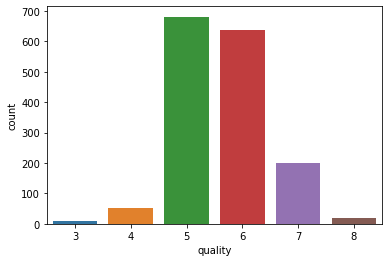

In [4]:
sns.countplot(x="quality",data=data)

In [5]:
#we separate our data
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [6]:
x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

In [8]:
#split into (train and val ) and test data
x_trainval, x_test, y_trainval, y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=69)

#split into train and validation set
x_train, x_val, y_train ,y_val = train_test_split(x_trainval,y_trainval,test_size=0.1,stratify=y_trainval,random_state=21)

In [9]:
#we need to normlize the inputs
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

#we transform the data to np arrays
x_train,y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

In [10]:
#we create a function that will give us the class distibution
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

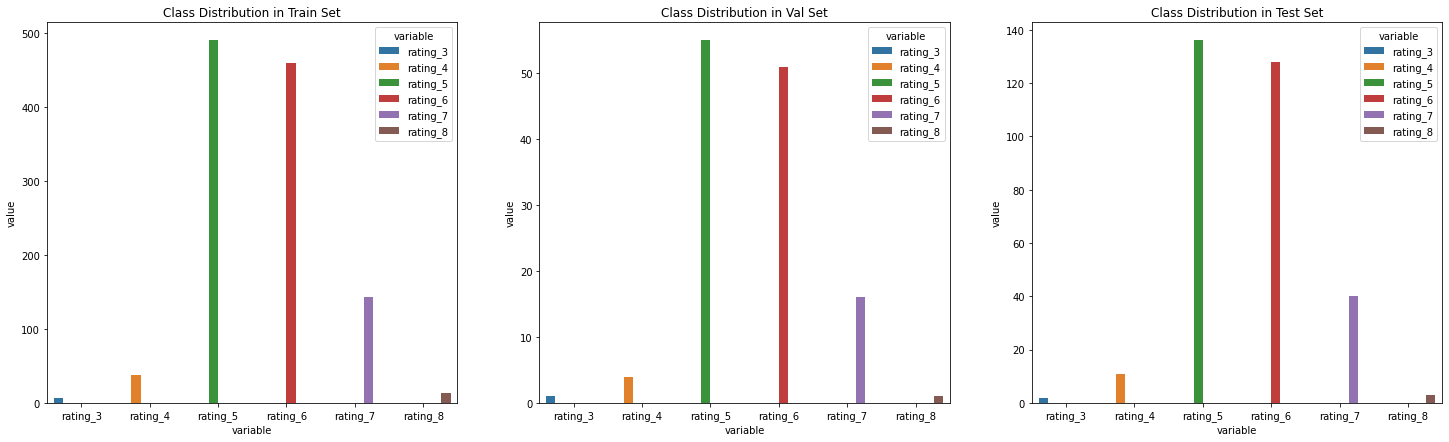

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Val
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [12]:
#we convert the outputs to float
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [13]:
#we create the class for the dataset
class RegressionDataset(Dataset):
  def __init__(self,x_data,y_data):
    self.x_data = x_data
    self.y_data = y_data

  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return len(self.x_data)

In [14]:
#we create the training dataset
train_dataset = RegressionDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())

In [15]:
#we create the validation dataset
val_dataset = RegressionDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())

In [16]:
#we create the test dataset
test_dataset = RegressionDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())

In [17]:
#we define the model params
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001

NUM_FEATURES = len(x.columns)

In [18]:
#we initialize the dataloader
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=1)
test_loader = DataLoader(test_dataset,batch_size=1)

In [19]:
#we create out neural network
class RegressionModel(nn.Module):
  def __init__(self,num_features):
    super(RegressionModel,self).__init__()

    self.layer_1 = nn.Linear(num_features,16)
    self.layer_2 = nn.Linear(16,32)
    self.layer_3 = nn.Linear(32,16)
    self.layer_out = nn.Linear(16,1)

    self.relu = nn.ReLU()

  def forward(self,inputs):
    x = self.relu(self.layer_1(inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))
    x = self.layer_out(x)

    return x

  def predict(self,test_inputs):
    x = self.relu(self.layer_1(test_inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))
    x = self.layer_out(x)

    return x



In [20]:
#we initialize our model, optimizer and our loss function
model = RegressionModel(NUM_FEATURES)

cretirion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [21]:
#we create a dictionary where we will store the loss stats for each epoch for training and validation
loss_stats = {
    "train" : [],
    "val":[]
}

In [22]:
#we train our model
print("Begin training!")

for e in tqdm(range(1,EPOCHS)):
  #TRAINING
  train_epoch_loss = 0
  model.train()
  #we eterate in each batch for our train_loader
  for x_train_batch,y_train_batch in train_loader:
    optimizer.zero_grad()
    y_train_pred = model(x_train_batch)

    train_loss = cretirion(y_train_pred, y_train_batch.unsqueeze(1))
    
    train_loss.backward()
    optimizer.step()
    train_epoch_loss += train_loss.item()
  
  #VALIDATION
  with torch.no_grad():
    val_epoch_loss = 0
    model.eval()
    #we eterate on each item of the validation dataset
    for x_val_batch, y_val_batch in val_loader:
      y_val_pred = model(x_val_batch)

      val_loss = cretirion(y_val_pred, y_val_batch.unsqueeze(1))

      val_epoch_loss += val_loss.item()
  
  loss_stats["train"].append(train_epoch_loss / len(train_loader))
  loss_stats["val"].append(val_epoch_loss / len(val_loader))

  print(f' For epoch {e} : Train loss = {train_epoch_loss / len(train_loader)}  and Val loss = {val_epoch_loss / len(val_loader)}')
    

Begin training!


 For epoch 1 : Train loss = 31.40135341220432  and Val loss = 30.474416188895702
 For epoch 2 : Train loss = 29.82938861846924  and Val loss = 28.600255448371172
 For epoch 3 : Train loss = 27.30700757768419  and Val loss = 25.08643878251314
 For epoch 4 : Train loss = 22.232950952317978  and Val loss = 17.82504483126104
 For epoch 5 : Train loss = 12.686496363745796  and Val loss = 6.275826974015217
 For epoch 6 : Train loss = 2.6189860304196677  and Val loss = 0.919801529468657
 For epoch 7 : Train loss = 0.9971262481477525  and Val loss = 0.9407330104589846
 For epoch 8 : Train loss = 0.7780591001113256  and Val loss = 0.8430836839729423
 For epoch 9 : Train loss = 0.7720068759388394  and Val loss = 0.8231046641799367
 For epoch 10 : Train loss = 0.7482034663359324  and Val loss = 0.8067835003598702
 For epoch 11 : Train loss = 0.7358065942923228  and Val loss = 0.7868855639521826
 For epoch 12 : Train loss = 0.7242086264822218  and Val loss = 0.7730843017279767
 For epoch 13 : Trai

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

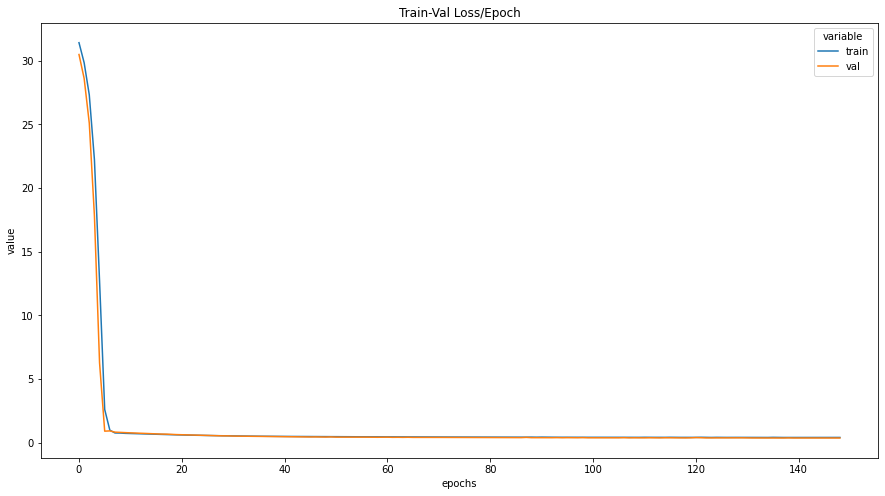

In [27]:
loss_stats_df = pd.DataFrame.from_dict(loss_stats)
loss_stats_df =loss_stats_df.reset_index().melt(id_vars=["index"]).rename(columns={"index":"epochs"})

plt.figure(figsize=(15,8))
sns.lineplot(data=loss_stats_df, x = "epochs", y="value",hue="variable").set_title('Train-Val Loss/Epoch')

In [28]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [30]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.4204297334834166
R^2 : 0.34844717130725444
